In [1]:
!printf '{"username":"_","key":"_"}' > kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
# !kaggle datasets download -d dhamur/cotton-plant-disease
!kaggle datasets download -d saeedazfar/customized-cotton-disease-dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/customized-cotton-disease-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

100% 1.92G/1.92G [01:10<00:00, 35.6MB/s]
100% 1.92G/1.92G [01:10<00:00, 29.3MB/s]


In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 100

In [5]:
import os

# Define the path to the parent folder containing the subfolders
parent_folder_path = '/content/Cotton-Disease-Training/trainning/Cotton leaves - Training/800 Images'

# Define the path to the new parent folder where processed images will be stored
new_parent_folder_path = '/content/Cotton-Disease-Training/trainning/Cotton leaves - Training/Processed_Images'

# Create the new parent folder if it doesn't exist
if not os.path.isdir(new_parent_folder_path):
    os.mkdir(new_parent_folder_path)

# List all subfolders in the parent folder
folder_paths = [f.path for f in os.scandir(parent_folder_path) if f.is_dir()]

for folder_path in folder_paths:
    # Extract the folder name to use it for the new folder structure
    folder_name = os.path.basename(folder_path)
    new_folder_path = os.path.join(new_parent_folder_path, folder_name)

    # Create the new folder if it doesn't exist
    if not os.path.isdir(new_folder_path):
        os.mkdir(new_folder_path)

    filenames = os.listdir(folder_path)

    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        try:
            img_bytes = open(img_path, 'rb').read()
            img = tf.io.decode_image(img_bytes)
            new_img_bytes = tf.io.encode_jpeg(img)
            new_img_path = os.path.join(new_folder_path, os.path.splitext(filename)[0] + '.jpg')
            tf.io.write_file(new_img_path, new_img_bytes)
        except Exception as e:
            print(f"Error processing image {filename} in folder {folder_path}: {e}")


Error processing image 1.jpg in folder /content/Cotton-Disease-Training/trainning/Cotton leaves - Training/800 Images/Cotton Boll Rot: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage]
Error processing image 16.jpg in folder /content/Cotton-Disease-Training/trainning/Cotton leaves - Training/800 Images/Cotton Boll Rot: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage]
Error processing image 2.jpg in folder /content/Cotton-Disease-Training/trainning/Cotton leaves - Training/800 Images/Cotton Boll Rot: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage]


In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    # "5 Black and white/5 Black and white",
    # "Cotton leaves/40 Images",
    "Cotton-Disease-Training/trainning/Cotton leaves - Training/Processed_Images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6625 files belonging to 8 classes.


In [7]:
class_names=dataset.class_names
class_names

['Aphids',
 'Army worm',
 'Bacterial blight',
 'Cotton Boll Rot',
 'Green Cotton Boll',
 'Healthy',
 'Powdery mildew',
 'Target spot']

(32, 256, 256, 3)
[4 1 3 3 7 4 4 1 7 2 1 1 0 0 1 7 3 2 3 0 4 6 2 7 1 2 4 4 6 3 1 3]


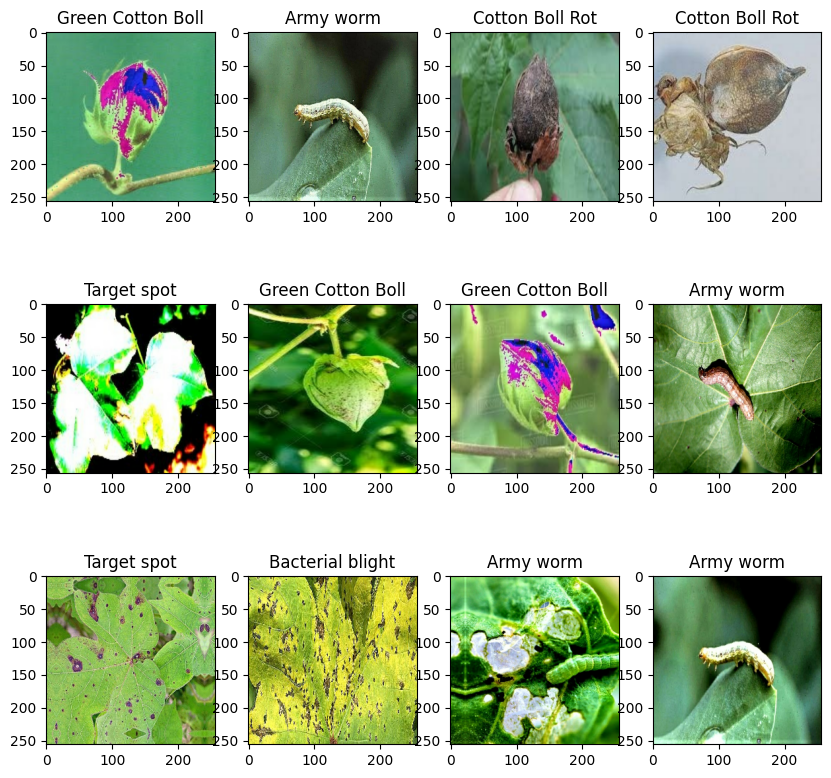

In [8]:
plt.figure(figsize=(10,10))
for image_batch,lables_batch in dataset.take(1):
    print(image_batch.shape)
    print(lables_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lables_batch[i]])

(32, 256, 256, 3)
[2 7 0 5 3 2 0 3 7 3 4 4 3 5 5 6 4 3 5 1 7 4 4 2 7 4 0 5 6 1 1 2]


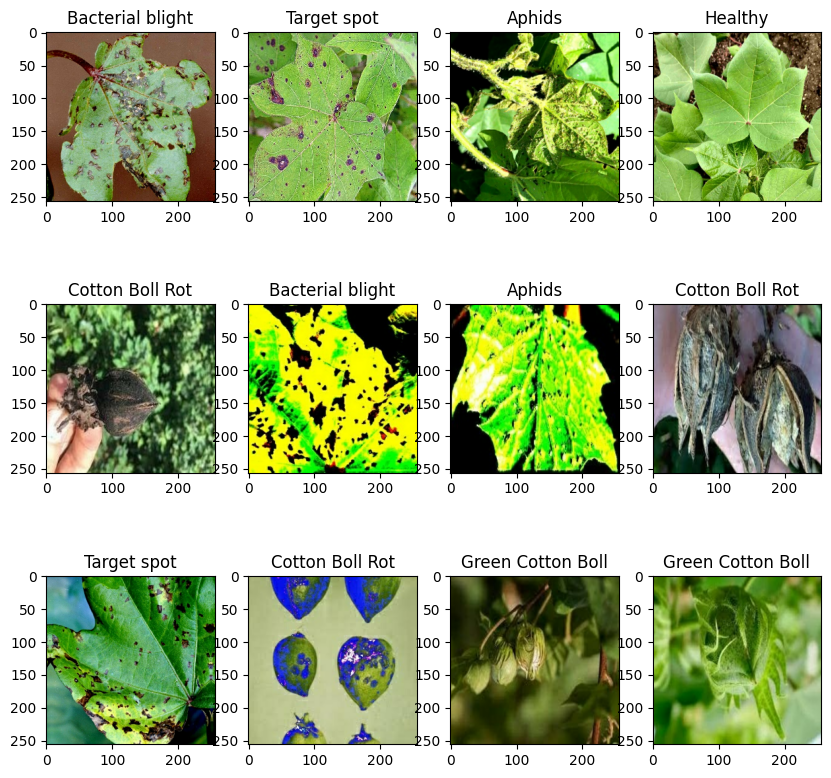

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,lables_batch in dataset.take(2):
    print(image_batch.shape)
    print(lables_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lables_batch[i]])

In [9]:
train_size=0.8
len(dataset)*train_size

166.4

In [10]:
train_ds = dataset.take(166)
len(train_ds)

166

In [11]:
test_ds = dataset.skip(166)
len(test_ds)

42

In [12]:
val_size = 0.1
len(dataset)*val_size

20.8

In [13]:
val_ds = test_ds.take(20)
len(val_ds)

20

In [14]:
test_ds = test_ds.skip(20)
len(test_ds)

22

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    # callbacks=[early_stop]
)

Epoch 1/100
166/166 [==============================] - 59s 186ms/step - loss: 1.9298 - accuracy: 0.2078 - val_loss: 1.7773 - val_accuracy: 0.2672
Epoch 2/100
166/166 [==============================] - 10s 60ms/step - loss: 1.7986 - accuracy: 0.2986 - val_loss: 1.7069 - val_accuracy: 0.3031
Epoch 3/100
166/166 [==============================] - 10s 60ms/step - loss: 1.6955 - accuracy: 0.3441 - val_loss: 1.5627 - val_accuracy: 0.4187
Epoch 4/100
166/166 [==============================] - 10s 60ms/step - loss: 1.4292 - accuracy: 0.4620 - val_loss: 1.2294 - val_accuracy: 0.5281
Epoch 5/100
166/166 [==============================] - 10s 60ms/step - loss: 1.2098 - accuracy: 0.5552 - val_loss: 1.1115 - val_accuracy: 0.5656
Epoch 6/100
166/166 [==============================] - 10s 60ms/step - loss: 1.0432 - accuracy: 0.6205 - val_loss: 0.9704 - val_accuracy: 0.6687
Epoch 7/100
166/166 [==============================] - 10s 60ms/step - loss: 0.8999 - accuracy: 0.6982 - val_loss: 0.7768 - val_a

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS=100

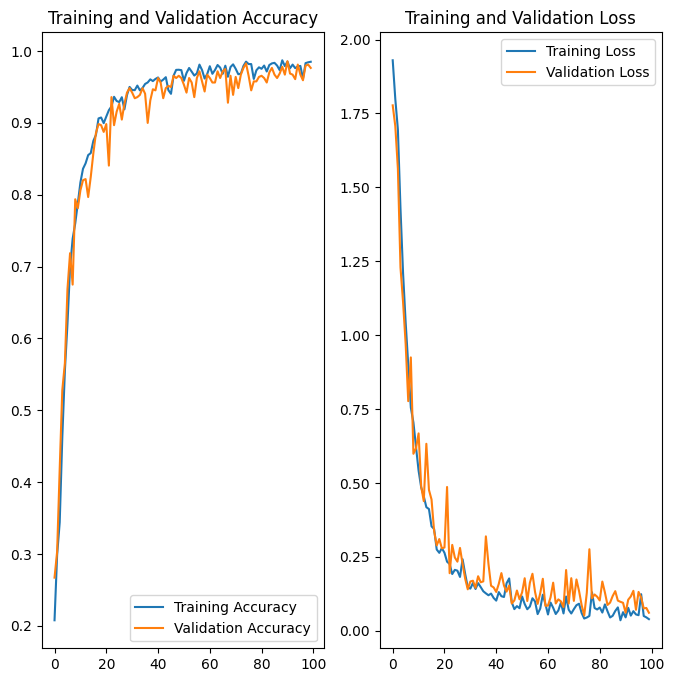

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

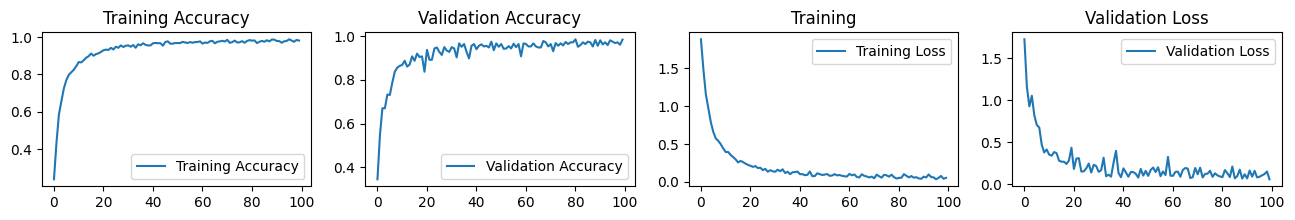

In [ ]:
plt.figure(figsize=(16, 2))
plt.subplot(1, 4, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 4, 2)
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 4, 3)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training')

plt.subplot(1, 4, 4)
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()



<Axes: >

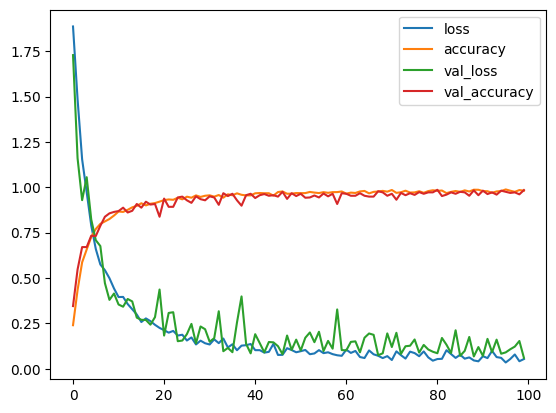

In [ ]:
pd.DataFrame(history.history).plot()

In [33]:
model.evaluate(test_ds)

22/22 [==============================] - 23s 40ms/step - loss: 0.0679 - accuracy: 0.9822


[0.06791528314352036, 0.9821693897247314]

In [34]:
model.save('Cotton_plant_disease_v1_98_22.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

In [ ]:
# import gc
# gc.collect()

10787